# TPS-2021-08
ローンのデフォルトによる損失(loss）の予測を行う。

In [1]:
# ライブラリのロード
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
import optuna.integration.lightgbm as opt_lgb

import sklearn.model_selection
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_squared_log_error 

from matplotlib import pyplot as plt
from itertools import product
import seaborn as sns
import io

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-aug-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2021/train.csv
/kaggle/input/tabular-playground-series-aug-2021/test.csv


In [3]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

sample_submission = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2021/sample_submission.csv')
train = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2021/test.csv')

In [4]:
train.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
0,0,-0.002350,59,0.766739,-1.350460,42.2727,16.68570,30.3599,1.267300,0.392007,1.09101,1.96874,1.874640,117.286,6.716200,0.985656,0.973428,4004232,0.377896,1.033820,0.574531,0.122371,8.18617,1517.830,3.13219,0.112836,5.01868,116.766,10891,8.19366,5.79715,1.09999,14.86840,-0.275434,0.915721,167.800,-7.534140,4.23632,1.629560,1.144400,-0.303139,4.092090,3.22617,0.074799,0.259497,289.4920,327.4650,5.389310,7.39479,-0.489950,20.2923,2.45660,1.447720,-10639.0,85.6005,-0.178513,2815,-234.772,1.83317,88.5605,0.367916,8.575340e+09,70.9733,0.380057,0.031812,1.09527,0.563482,0.122689,1.160720,1.69391,1.07217,65.1543,0.022504,-5.6068,1.798660,0.528068,6696.300,-0.562078,1.301020,6.71624,1.143470,2.29983,0.010485,-0.127223,0.231086,4.51614,0.594494,397,0.264022,8.68790,15.070100,0.376622,-42.43990,26.854000,1.45751,0.696161,0.941764,1.828470,0.924090,2.29658,10.48980,15
1,1,0.784462,145,-0.463845,-0.530421,27324.9000,3.47545,160.4980,0.828007,3.735860,1.28138,-2.73947,-0.529506,157.670,0.696384,1.441230,0.159056,23567462,-0.089583,-0.711628,-1.045860,0.139920,3.69294,-123.354,7.74097,-0.852302,8.51025,161.175,87801,12.02020,1.78393,1.23100,10.14970,-0.018724,1.011280,127.401,11.821400,5.99681,-0.953850,1.379370,1.079530,0.711923,2.90602,0.051206,0.755122,140.8930,29.5252,14.229600,3.53213,-0.405681,42.5357,1.43533,0.939771,138312.0,59.8810,-0.070959,1435,1046.880,1.56770,29.4306,2.455150,4.518200e+09,75.5602,1.987990,0.318177,1.14901,0.723574,0.184821,-0.348303,-7.17633,1.46258,43.1121,-0.060801,64.0455,2.358450,5.759690,3958.140,1.576610,-1.241790,5.91412,0.959826,2.56631,0.000652,-0.335617,-0.271723,5.10319,8.706220,98,0.210513,7.86416,3.371900,0.147973,-184.13200,7.901370,1.70644,-0.494699,-2.058300,0.819184,0.439152,2.36470,1.14383,3
2,2,0.317816,19,-0.432571,-0.382644,1383.2600,19.71290,31.1026,-0.515354,34.430800,1.24210,2.90180,-0.960340,118.590,7.696420,1.488760,0.387277,235760,0.055568,0.268560,0.718133,0.027133,11.67340,270.247,3.44051,-0.679071,13.37810,150.362,14173,1.69954,7.04728,1.10513,7.62871,0.685721,0.809485,120.064,194.427000,6.77866,0.634136,0.934386,0.926980,0.741116,2.42205,0.260362,0.626639,369.5790,370.0240,4.488930,7.84290,1.196010,43.5343,2.59182,1.256710,168881.0,83.8419,2.713230,2911,23256.900,3.91896,97.5578,4.385380,8.444970e+08,99.4933,5.098040,0.258909,1.16878,0.049053,0.173547,0.937000,2.05947,1.22245,50.2267,-0.026215,71.6849,2.434170,1.904560,27165.800,-0.773223,-1.833390,4.98548,1.170870,1.17201,0.016848,-0.235581,-0.724935,3.22565,4.170990,105,-0.155451,8.91829,0.186334,0.335985,7.43721,37.218100,3.25339,0.337934,0.615037,2.216760,0.745268,1.69679,12.30550,6
3,3,0.210753,17,-0.616454,0.946362,-119.2530,4.08235,185.2570,1.383310,-47.521400,1.09130,-1.51200,-1.292340,125.461,7.343230,-3.092390,0.713795,1146032,0.326534,0.454842,0.219958,0.037982,5.15195,4893.860,6.89751,-0.830552,4.43184,132.855,77147,32.80900,4.06390,1.11911,3.91776,0.500353,0.206448,120.411,233.537000,7.75131,0.625762,-1.940810,1.333210,-5.793170,1.56512,0.309483,0.134558,84.8637,24.3353,4.871200,2.55104,-0.372300,14.8960,1.10013,0.892193,17006.6,78.4078,0.425686,1723,375.240,1.94539,98.1500,-0.109164,3.543970e+09,60.8082,2.357590,0.239080,1.16116,0.535797,0.222185,1.163120,2.36343,1.41530,116.1820,0.018674,55.4428,2.228240,4.303600,2643.760,-1.666320,0.792398,6.45162,1.077330,2.90676,0.023735,-0.091992,-0.098701,4.27820,5.347530,512,0.855981,8.27663,4.066650,0.336490,9.66778,0.626942,1.49425,0.517513,-10.222100,2.627310,0.617270,1.45645,10.02880,2
4,4,0.439671,20,0.968126,-0.092546,74.3020,12.30650,72.1860,-0.233964,24.399100,1.10151,1.77348,

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Columns: 102 entries, id to loss
dtypes: float64(95), int64(7)
memory usage: 194.5 MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Columns: 101 entries, id to f99
dtypes: float64(95), int64(6)
memory usage: 115.6 MB


In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,250000.0,1.249995e+05,7.216893e+04,0.000000e+00,6.249975e+04,1.249995e+05,1.874992e+05,2.499990e+05
f0,250000.0,5.112127e-01,3.078836e-01,-6.927340e-02,2.512868e-01,5.149625e-01,7.773225e-01,1.072070e+00
f1,250000.0,5.137848e+01,4.239664e+01,-1.700000e+01,1.800000e+01,4.100000e+01,7.500000e+01,2.730000e+02
f2,250000.0,1.071554e-01,1.322200e+00,-7.895580e+00,-6.111722e-01,2.538155e-01,7.592492e-01,9.768590e+00
f3,250000.0,5.001007e-02,7.923683e-01,-1.475560e+00,-7.194175e-01,4.098870e-03,7.654560e-01,1.680190e+00
f4,250000.0,3.595133e+03,6.072401e+03,-7.589280e+03,1.638648e+02,9.430005e+02,4.115355e+03,3.784750e+04
f5,250000.0,8.205953e+00,5.475723e+00,-3.291050e+00,4.110127e+00,7.472445e+00,1.103095e+01,3.507800e+01
f6,250000.0,1.645088e+02,1.833356e+02,-4.096720e+01,2.789490e+01,9.100525e+01,2.408438e+02,9.471430e+02
f7,250000.0,3.755328e-01,8.135966e-01,-4.143080e+00,-2.624490e-02,6.198620e-01,9.338547e-01,4.010380e+00
f8,250000.0,1.666974e+01,9.975871e+01,-5.028130e+02,-1.739203e+01,8.714945e+00,5.540763e+01,4.659560e+02


In [8]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,150000.0,3.249995e+05,4.330141e+04,2.500000e+05,2.874998e+05,3.249995e+05,3.624992e+05,3.999990e+05
f0,150000.0,5.131371e-01,3.075122e-01,-6.417150e-02,2.548973e-01,5.168550e-01,7.782998e-01,1.072210e+00
f1,150000.0,5.161238e+01,4.266221e+01,-1.700000e+01,1.800000e+01,4.100000e+01,7.600000e+01,2.700000e+02
f2,150000.0,1.081662e-01,1.338636e+00,-7.952920e+00,-6.150630e-01,2.531620e-01,7.594302e-01,9.931070e+00
f3,150000.0,4.779348e-02,7.908938e-01,-1.491030e+00,-7.187303e-01,3.786360e-03,7.617932e-01,1.670420e+00
f4,150000.0,3.567849e+03,6.045627e+03,-7.801580e+03,1.617970e+02,9.350885e+02,4.076673e+03,3.843440e+04
f5,150000.0,8.189529e+00,5.443633e+00,-3.097580e+00,4.129198e+00,7.467945e+00,1.101660e+01,3.453300e+01
f6,150000.0,1.633032e+02,1.817993e+02,-3.902010e+01,2.777475e+01,9.009035e+01,2.399530e+02,9.432970e+02
f7,150000.0,3.798491e-01,8.125153e-01,-4.062280e+00,-2.404100e-02,6.222880e-01,9.367720e-01,4.183330e+00
f8,150000.0,1.662687e+01,9.981330e+01,-4.963260e+02,-1.778030e+01,8.433805e+00,5.505307e+01,4.665350e+02


In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   id      150000 non-null  int64
 1   loss    150000 non-null  int64
dtypes: int64(2)
memory usage: 2.3 MB


In [10]:
heatmap = train
heatmap.corr()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
id,1.000000,0.000625,0.000333,0.000876,-0.000328,0.001605,-0.001489,-0.002093,0.001868,-0.006448,0.002393,-0.002228,-0.000869,-0.001399,0.000237,-0.001203,-0.000255,-0.004194,-0.000190,0.004639,-0.001501,-0.000174,-0.001166,0.000010,-0.002645,0.001443,0.002277,-0.001516,0.002338,-0.000177,-0.000903,-0.002768,0.000565,-0.000855,-0.000871,0.000487,0.000170,-0.000304,0.001460,0.004882,0.001112,0.003687,0.000842,0.000314,-0.001017,0.004449,0.001240,-0.001580,0.002239,-0.002985,-0.001625,0.000225,0.004147,0.000476,0.001118,0.003724,-0.003378,-0.001644,0.001408,-0.001670,-0.002290,0.004328,0.004254,-0.003533,0.003240,-0.000339,-0.006241,-0.000701,0.000766,-0.001939,0.001545,0.001970,-0.000880,0.001386,-0.000269,-0.001895,-0.004284,0.002069,0.002216,-0.001980,-0.002743,0.001956,-0.005361,-2.233029e-04,0.004256,0.001861,-0.001551,0.000429,-0.003595,-0.001425,0.001034,-0.000110,0.000919,-0.000568,0.003579,0.000276,5.918249e-05,0.001217,0.007288,0.003547,0.001189,0.001020
f0,0.000625,1.000000,-0.004339,-0.004808,0.004662,0.001170,0.012141,0.002686,-0.003814,-0.000343,-0.007426,0.002852,-0.011129,0.006671,0.016323,0.002159,0.006979,0.003048,0.002987,0.011259,-0.006806,0.002673,-0.003676,-0.010313,-0.007437,-0.002003,-0.000222,0.011491,-0.000688,-0.004125,-0.000790,-0.006728,0.007992,0.008025,0.003360,0.000380,0.002429,0.000762,0.004753,0.005545,0.003745,-0.002652,-0.000844,-0.005031,-0.011736,-0.001125,-0.001575,-0.004361,-0.005510,-0.002440,-0.005345,-0.004037,0.003029,-0.005417,-0.004501,0.004192,0.004534,-0.003250,-0.004354,0.001361,0.000772,0.006516,-0.000024,-0.006133,0.004114,0.000142,-0.000131,-0.013484,-0.000609,0.010863,0.010468,-0.000117,-0.003921,0.000694,-0.004010,0.005217,0.013212,-0.002975,0.008004,-0.004434,0.008075,-0.001495,-0.000214,-3.113757e-04,0.013692,0.003405,-0.009292,0.002168,0.001788,0.008519,-0.004024,0.004457,0.001487,-0.010135,0.006754,0.000346,2.565584e-03,-0.003691,0.000916,-0.005810,0.010797,0.008921
f1,0.000333,-0.004339,1.000000,-0.005421,0.000400,-0.002447,0.012614,-0.001040,-0.004030,-0.014389,0.002277,0.014083,-0.000023,0.009007,0.000058,-0.001461,0.002241,0.005774,-0.005579,-0.002796,-0.002909,-0.005902,-0.004420,-0.000284,0.012254,0.007612,-0.002469,-0.003194,-0.000993,0.007772,0.008089,0.004737,-0.000374,0.007414,0.010907,0.000842,0.004428,-0.007986,0.010490,-0.002065,-0.002680,-0.000093,0.011884,-0.006966,0.002381,0.000221,-0.000051,0.008134,-0.005755,-0.020660,0.011159,0.000800,0.002848,-0.001539,0.013374,0.003022,-0.001888,0.011025,-0.001967,-0.009692,-0.002248,0.003332,-0.003054,-0.016643,0.004907,0.015325,0.002148,-0.002642,0.007553,0.002097,0.007109,-0.006184,0.006653,-0.004572,0.001087,0.011107,0.002765,0.001576,-0.000922,-0.011008,-0.000402,0.007026,0.006741,-2.686390e-03,-0.003026,0.003214,0.007369,0.002761,0.001005,-0.002728,-0.001524,-0.011887,-0.004757,-0.005882,0.000846,0.018600,3.927170e-03,-0.010261,0.001508,-0.009793,-0.002633,0.011847
f2,0.000876,-0.004808,-0.005421,1.000000,-0.007057,-0.004661,-0.015663,-0.002435,-0.008019,-0.001225,-0.011955,0.005394,0.004100,-0.002582,-0.011836,0.002604,0.002469,0.002886,-0.004163,-0.020238,-0.000995,-0.001444,0.013192,-0.013199,-0.002376,0.009503,-0.019411,-0.009402,0.003751,0.011396,0.009249,0.007058,-0.005693,-0.005668,0.026939,0.007577,0.000373,-0.003186,-0.011018,0.011487,-0.006934,0.002222,-0.003555,-0.003098,-0.016208,0.013900,0.016725,-0.019453,0.006724,0.012223,-0.003860,-0.006351,-0.002579,-0.009227,0.008706,-0.006925,-0.004612,-0.001510,-0.002754,0.009204,0.006753,0.001007,0.006407,-0.001182,-0.005979,0.003603,0.001453,0.011849,-0.008353,-0.01

In [11]:
#corr = heatmap.corr()
#sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
#plt.figure(figsize=(36,18))
#a = sns.heatmap(corr, annot=True, fmt='.2f')
#rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
#roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

In [12]:
train.loc[:,'test'] = 0
test.loc[:,'test'] = 1

df = train.append(test, ignore_index=False)

# 正規化
cols = df.drop(columns=['id','loss']).columns.values.tolist()
for col in cols:
    df.loc[:, col] = preprocessing.minmax_scale(df[col])

In [13]:
# 学習データを抽出
tmp_df = df[df['test'] == 0]
tmp_df = tmp_df.drop(columns='test')

train_df, valid_df = sklearn.model_selection.train_test_split(tmp_df, test_size=0.3, train_size = 0.7, random_state = 0)

pred_df = df[df['test'] == 1]
pred_df = pred_df.drop(columns=['test','loss'])

In [14]:
#params = {
# 'task': 'train',
# 'boosting_type': 'gbdt',    
# 'objective': 'regression',
# 'metric': 'rmse',
# 'learning_rate': 0.01, 

 #'feature_pre_filter': False,
 #'num_leaves': 16,
 #'feature_fraction': 0.5,
 #'bagging_fraction': 0.9321963910217531,
 #'bagging_freq': 4,
 #'min_child_samples': 20,

 #'num_iterations': 9999,
 #'early_stopping_round': 100,
 #'verbosity': -1
#}
# 'learning_rate': 0.009, [5149]	train's rmse: 7.47207	valid's rmse: 7.83708
# 'learning_rate': 0.01,  [5073]	train's rmse: 7.43782	valid's rmse: 7.83712
# 'learning_rate': 0.011, [3894]	train's rmse: 7.50026	valid's rmse: 7.8388
# 'learning_rate': 0.02,  [1919]	train's rmse: 7.53641	valid's rmse: 7.84118

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'feature_pre_filter': False,
    'num_leaves': 43,
    'feature_fraction': 0.652,
    'bagging_fraction': 0.7983154582927062,
    'bagging_freq': 3,
    'verbosity': -1,
    'min_data_in_leaf': 20,
    'lambda_l1': 0.004432688401347667,
    'lambda_l2': 3.233581403069381,
    'min_child_samples': 20,
    'num_iterations': 9999, 
    'early_stopping_round': 100
}


In [15]:
train_ds = lgb.Dataset(train_df.drop(columns=['id','loss']), label=train_df['loss'])
valid_ds = lgb.Dataset(valid_df.drop(columns=['id','loss']), label=valid_df['loss'])

In [16]:
# ハイパラチューニング
#model_o = opt_lgb.train(
#    params,
#    train_ds,
#    valid_names=['train', 'valid'],
#    valid_sets=[train_ds, valid_ds],
#    verbose_eval=100,
#    early_stopping_rounds=100
#)

In [17]:
#model_o.best_score

In [18]:
#prms = model_o.params
#print(prms)
prms = params
# {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.01, 'feature_pre_filter': False, 'num_leaves': 43, 'feature_fraction': 0.652, 'bagging_fraction': 0.7983154582927062, 'bagging_freq': 3, 'verbosity': -1, 'min_data_in_leaf': 20, 'lambda_l1': 0.004432688401347667, 'lambda_l2': 3.233581403069381, 'min_child_samples': 20, 'num_iterations': 9999, 'early_stopping_round': 100}


In [19]:
model = lgb.train(
    prms,
    train_ds,
    valid_names=['train', 'valid'],
    valid_sets=[train_ds, valid_ds],
    verbose_eval=100
)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.88859	valid's rmse: 7.9014
[200]	train's rmse: 7.84635	valid's rmse: 7.88613
[300]	train's rmse: 7.80882	valid's rmse: 7.87567
[400]	train's rmse: 7.77444	valid's rmse: 7.86817
[500]	train's rmse: 7.74199	valid's rmse: 7.86201
[600]	train's rmse: 7.71123	valid's rmse: 7.85754
[700]	train's rmse: 7.68181	valid's rmse: 7.85362
[800]	train's rmse: 7.65341	valid's rmse: 7.85091
[900]	train's rmse: 7.62576	valid's rmse: 7.84827
[1000]	train's rmse: 7.59922	valid's rmse: 7.84655
[1100]	train's rmse: 7.57324	valid's rmse: 7.84535
[1200]	train's rmse: 7.54791	valid's rmse: 7.84432
[1300]	train's rmse: 7.52323	valid's rmse: 7.84301
[1400]	train's rmse: 7.4989	valid's rmse: 7.8422
[1500]	train's rmse: 7.4753	valid's rmse: 7.84127
[1600]	train's rmse: 7.45198	valid's rmse: 7.84091
[1700]	train'

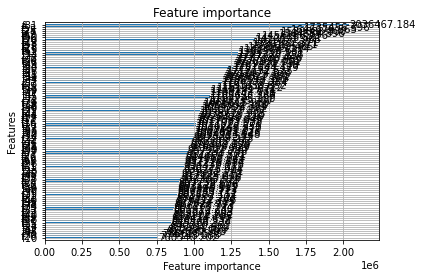

In [20]:
# 特徴量の重要度をプロットする
lgb.plot_importance(model, importance_type='gain')
plt.show()

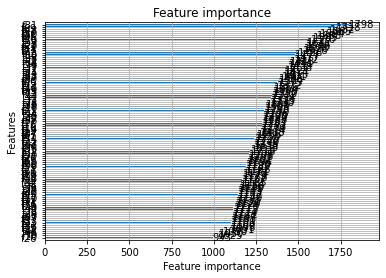

In [21]:
lgb.plot_importance(model, importance_type='split')
plt.show()

In [22]:
val_pred = model.predict(pred_df.drop(columns='id'))

In [23]:
print(val_pred)

[7.28343384 5.15716511 7.8177121  ... 6.12217646 4.7530154  6.34439348]


In [24]:
submission = pd.DataFrame({
    'id' : pred_df['id'],
    'loss' : val_pred
})

In [25]:
submission.head()

,id,loss
0,250000,7.283434
1,250001,5.157165
2,250002,7.817712
3,250003,6.539256
4,250004,7.389485


In [26]:
submission.to_csv('submission.csv', index=False)